<a href="https://www.kaggle.com/code/kshitij123456/notebook7e95966f02?scriptVersionId=247162216" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
import pandas as pd
import numpy as np

# Define outlets and items
outlets = ["Tollygunge", "New Town", "Nagerbazar", "Kalindi", "Baguiati"]

# Item and their prices (below ₹100)
items_with_prices = {
    "Choco Muffin": 25,
    "Veg Puff": 29,
    "Red Velvet Muffin": 30,
    "Apple Cake Slice": 25,
    "Butterscotch Pastry": 35
}

months = pd.date_range(start="2022-01-01", periods=24, freq="MS")

np.random.seed(42)
data = []

# Generate sales data with prices
for outlet in outlets:
    for item, price in items_with_prices.items():
        base = np.random.randint(150, 300)
        trend = np.linspace(0, 100, len(months))
        noise = np.random.randint(-30, 30, len(months))
        sales = base + trend + noise
        sales = np.maximum(sales, 0).astype(int)

        for date, sale in zip(months, sales):
            data.append([outlet, item, date.strftime("%Y-%m"), sale, price])

# Create DataFrame
df = pd.DataFrame(data, columns=["Outlet", "Item", "Month", "Sales", "Price"])

# Save to CSV
df.to_csv('kreamz_sales_detailed.csv', index=False)

print("File saved as kreamz_sales_detailed.csv")


File saved as kreamz_sales_detailed.csv


In [3]:
print (df.head())

       Outlet          Item    Month  Sales  Price
0  Tollygunge  Choco Muffin  2022-01    273     25
1  Tollygunge  Choco Muffin  2022-02    254     25
2  Tollygunge  Choco Muffin  2022-03    244     25
3  Tollygunge  Choco Muffin  2022-04    277     25
4  Tollygunge  Choco Muffin  2022-05    246     25


In [4]:
df = pd.read_csv('kreamz_sales_detailed.csv', parse_dates=['Month'])
df['Month'] = pd.to_datetime(df['Month'])


In [5]:
low_price_df = df[df['Price'] < 100].copy()
low_price_df['revenue'] = low_price_df['Price'] * low_price_df['Sales']

In [6]:
print (low_price_df.head())

       Outlet          Item      Month  Sales  Price  revenue
0  Tollygunge  Choco Muffin 2022-01-01    273     25     6825
1  Tollygunge  Choco Muffin 2022-02-01    254     25     6350
2  Tollygunge  Choco Muffin 2022-03-01    244     25     6100
3  Tollygunge  Choco Muffin 2022-04-01    277     25     6925
4  Tollygunge  Choco Muffin 2022-05-01    246     25     6150


In [7]:
grouped = low_price_df.groupby(['Outlet', 'Month']).agg({'revenue': 'sum'}).reset_index()


In [8]:
print(grouped.head())

     Outlet      Month  revenue
0  Baguiati 2022-01-01    29068
1  Baguiati 2022-02-01    28819
2  Baguiati 2022-03-01    29583
3  Baguiati 2022-04-01    30004
4  Baguiati 2022-05-01    31203


In [9]:

# Prepare to collect forecasts
forecast_data = []

# Forecast each item-outlet combo
unique_combos = low_price_df.groupby(['Outlet', 'Item'])

for (outlet, item), group in unique_combos:
    group = group.sort_values('Month')
    sales_ts = group.set_index('Month')['Sales']

    # Ensure monthly frequency
    sales_ts = sales_ts.asfreq('MS')

    try:
        # Fit ARIMA(1,1,1)
        model = ARIMA(sales_ts, order=(1, 1, 1))
        model_fit = model.fit()

        # Forecast next 12 months
        forecast = model_fit.forecast(steps=12)
        forecast_months = pd.date_range(sales_ts.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')

        for date, sale in zip(forecast_months, forecast):
            forecast_data.append({
                'Outlet': outlet,
                'Item': item,
                'Forecast_Month': date.strftime('%Y-%m'),
                'Forecasted_Sales': int(sale)
            })

    except Exception as e:
        print(f"Error in {outlet} - {item}: {e}")

# Create DataFrame with results
forecast_df = pd.DataFrame(forecast_data)
forecast_df.to_csv("kreamz_forecast_12months.csv", index=False)
print("Forecasts saved as kreamz_forecast_12months.csv")

# Optional: Display first few forecasts
print(forecast_df.head())

Forecasts saved as kreamz_forecast_12months.csv
     Outlet              Item Forecast_Month  Forecasted_Sales
0  Baguiati  Apple Cake Slice        2024-01               259
1  Baguiati  Apple Cake Slice        2024-02               260
2  Baguiati  Apple Cake Slice        2024-03               260
3  Baguiati  Apple Cake Slice        2024-04               260
4  Baguiati  Apple Cake Slice        2024-05               260


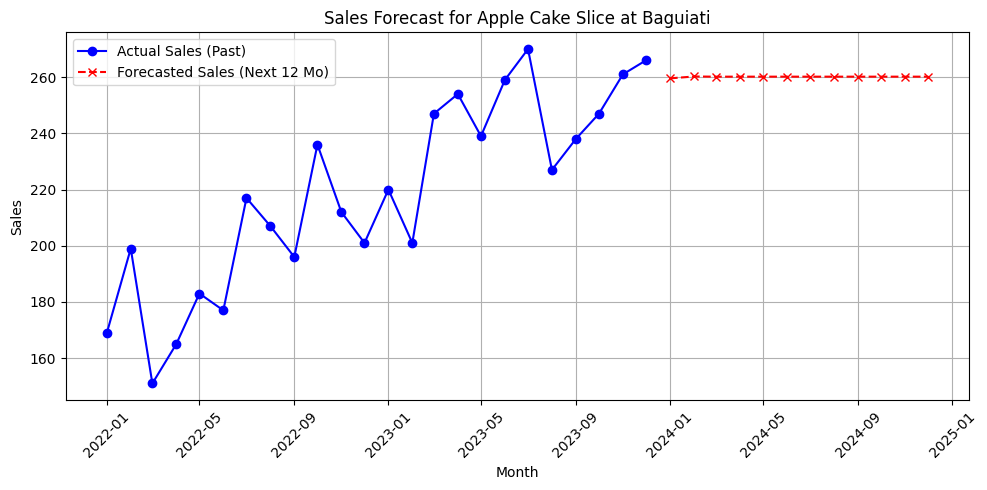

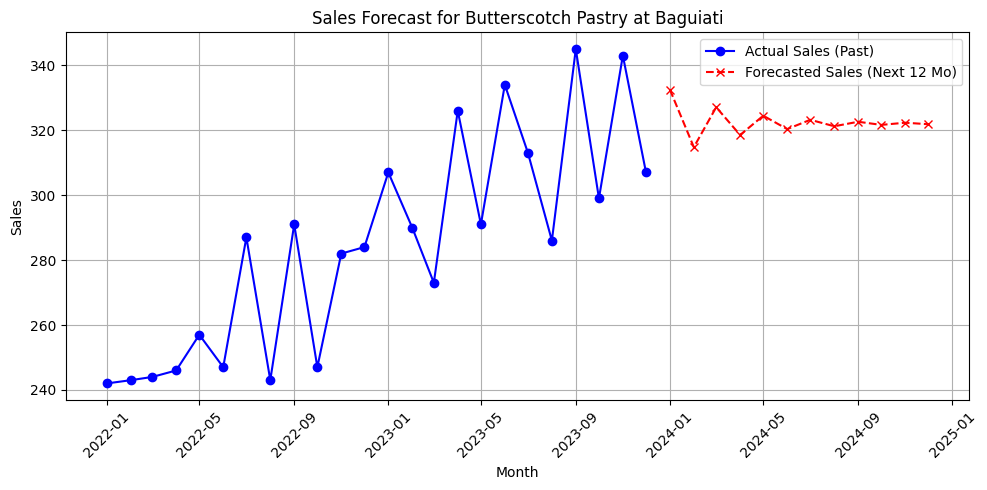

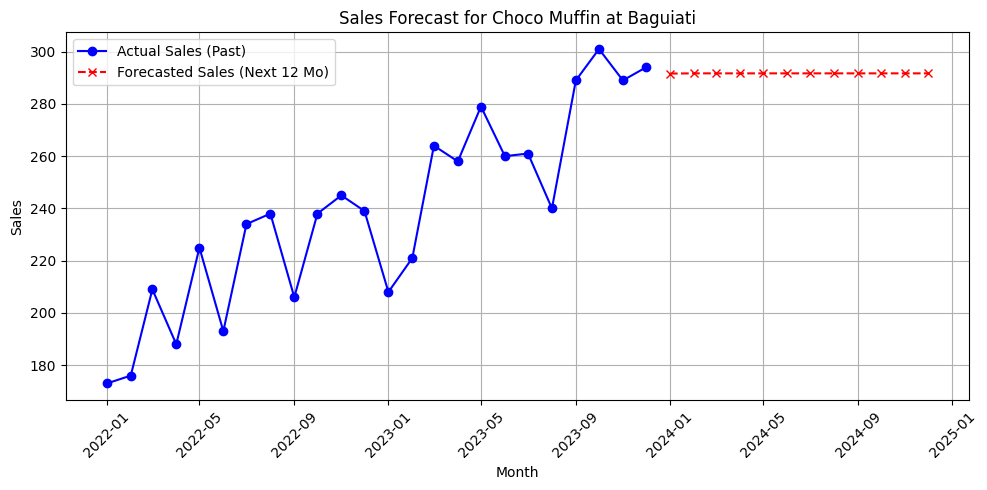

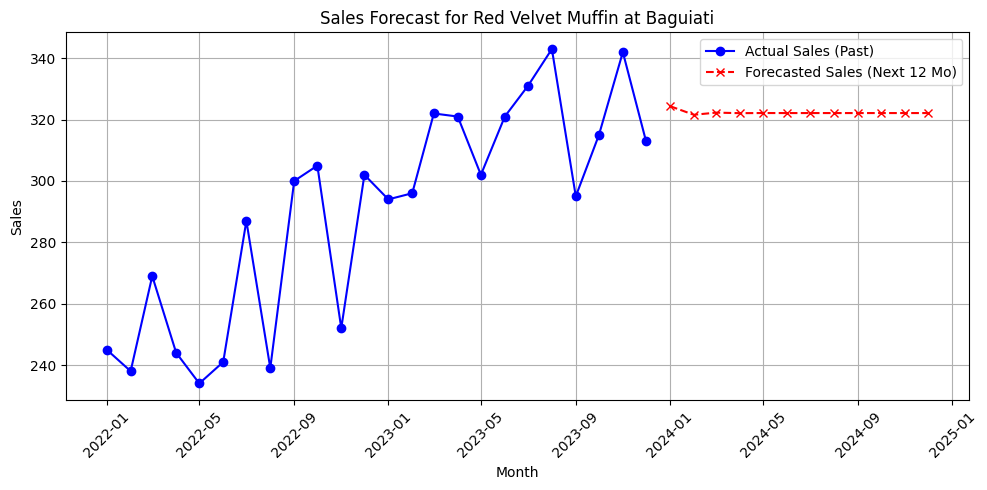

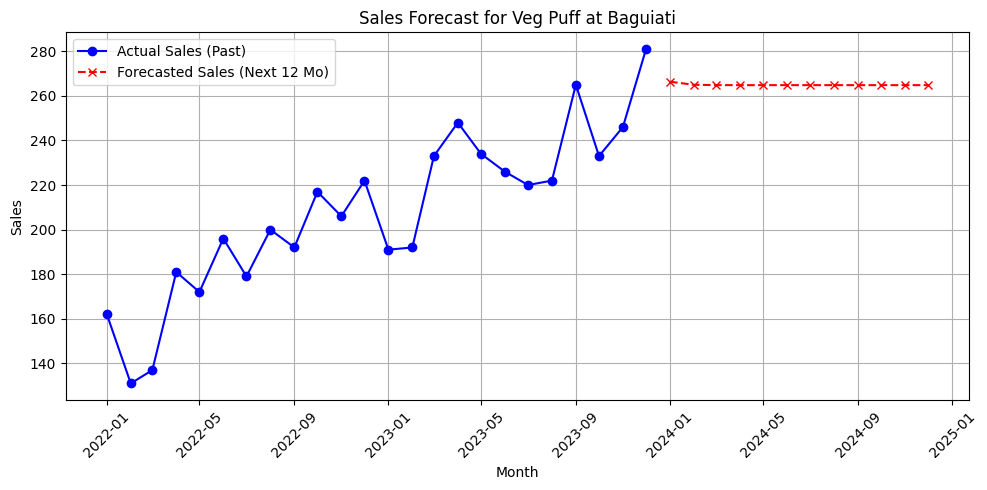

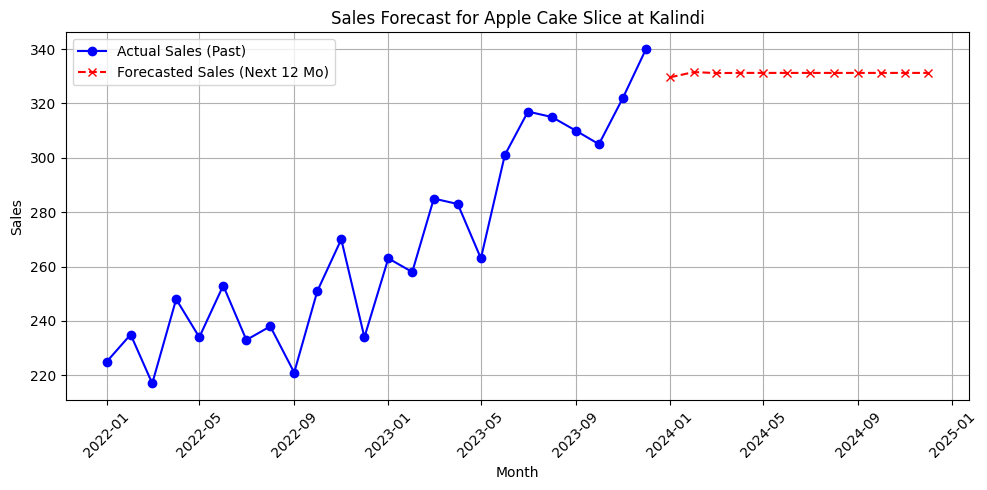

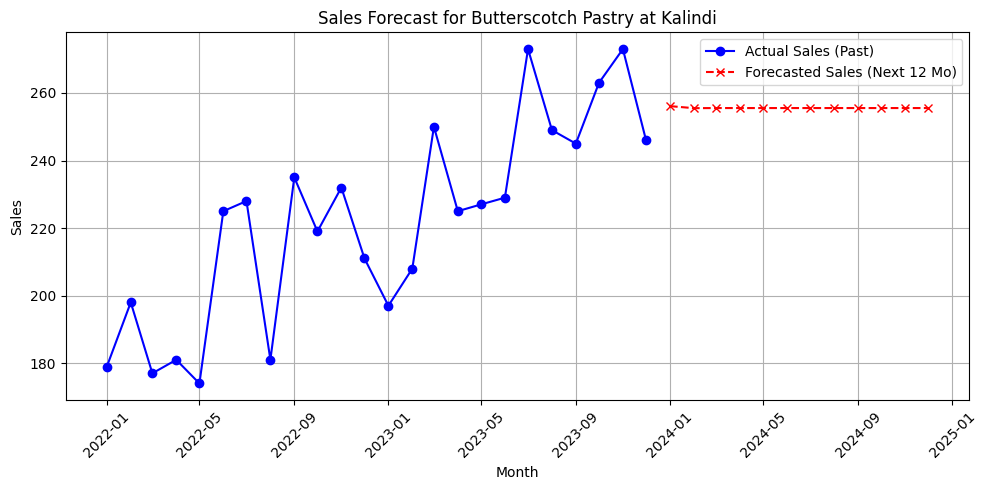

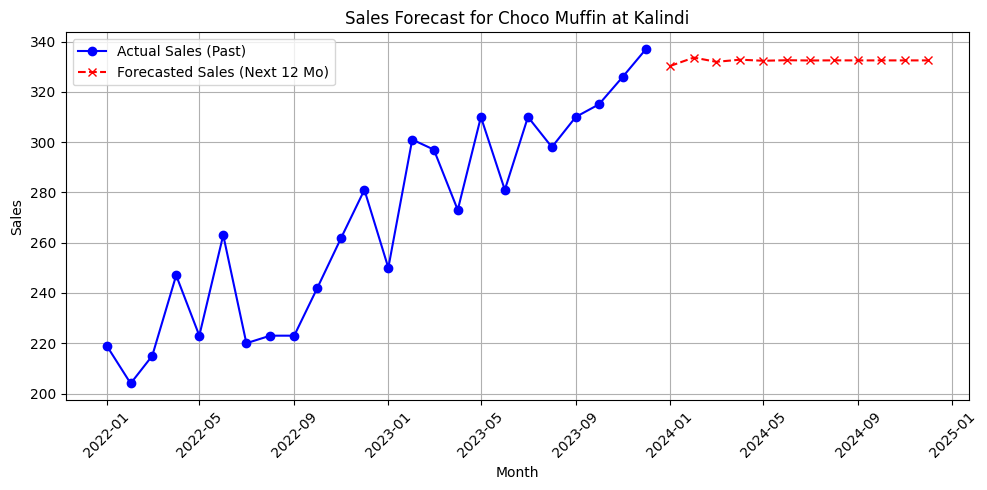

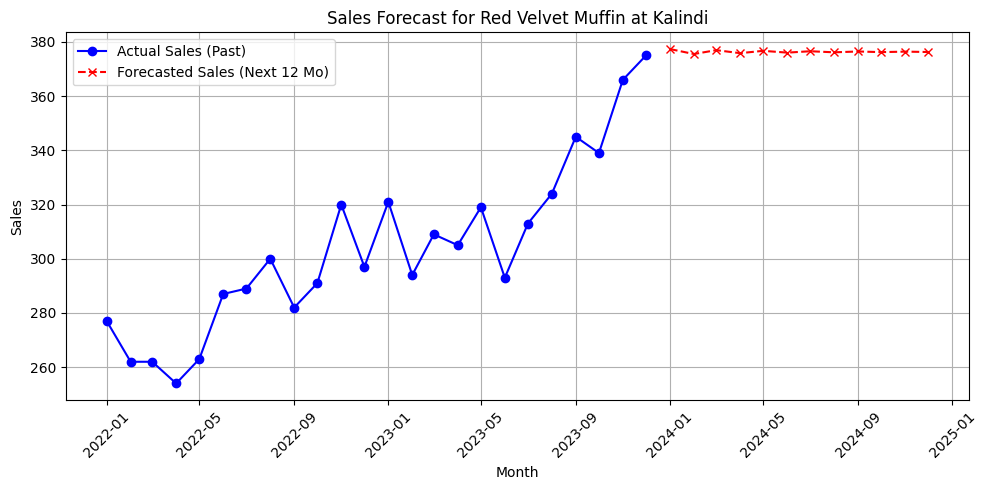

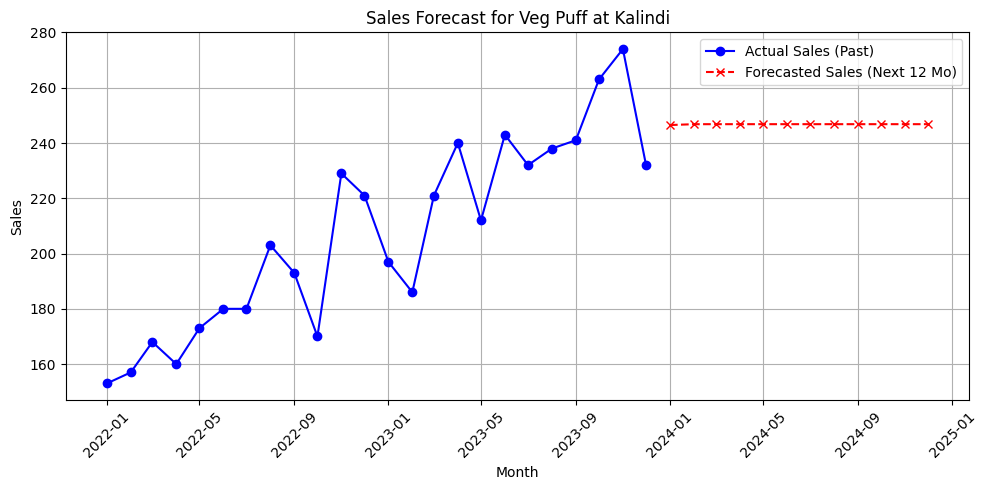

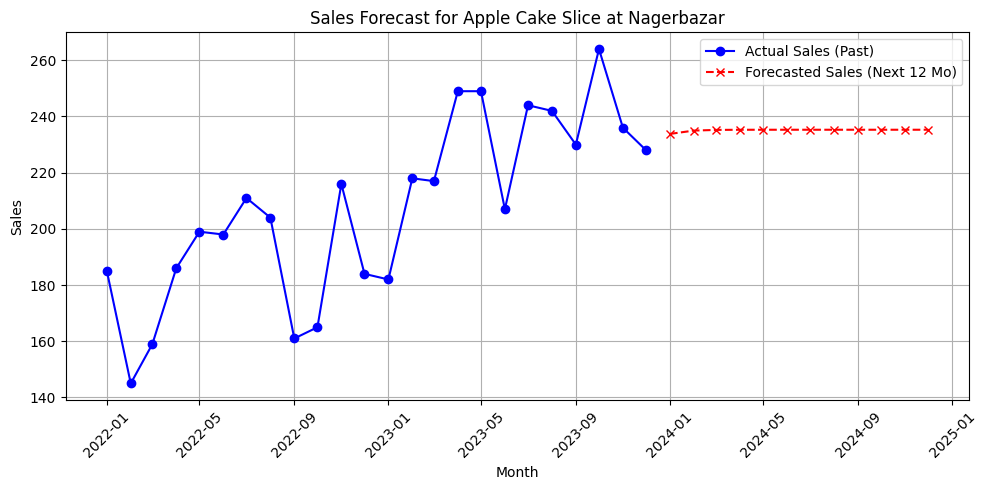

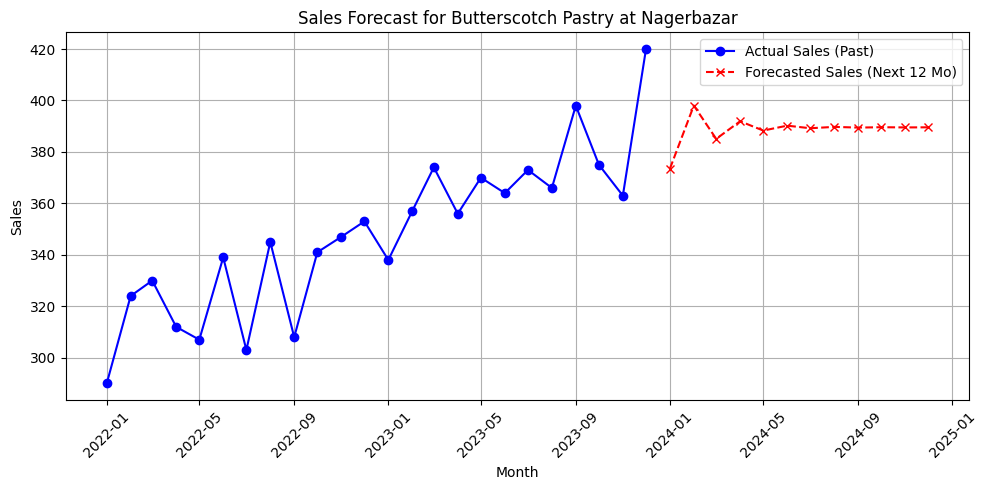

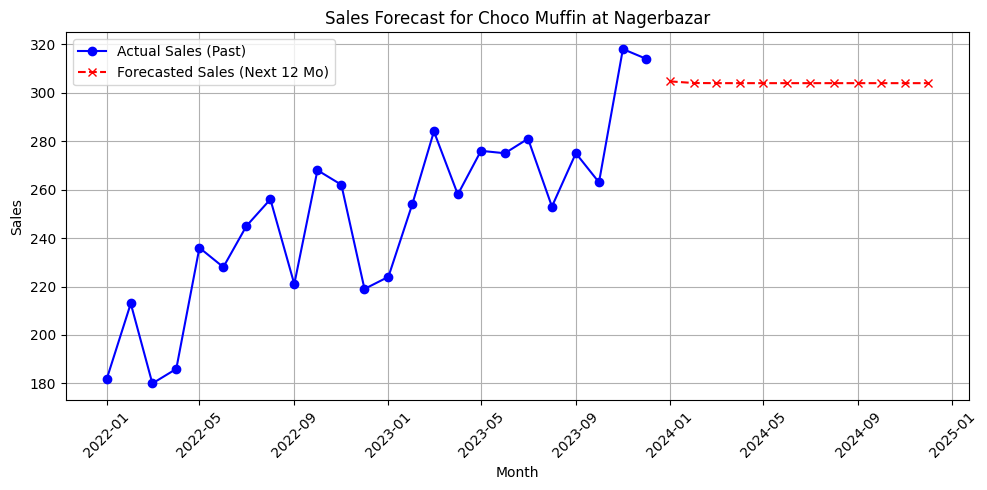

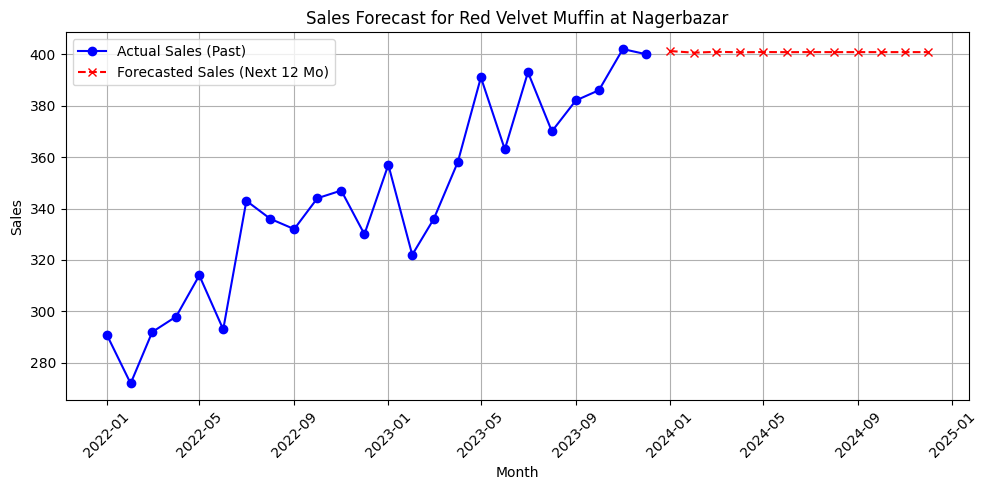

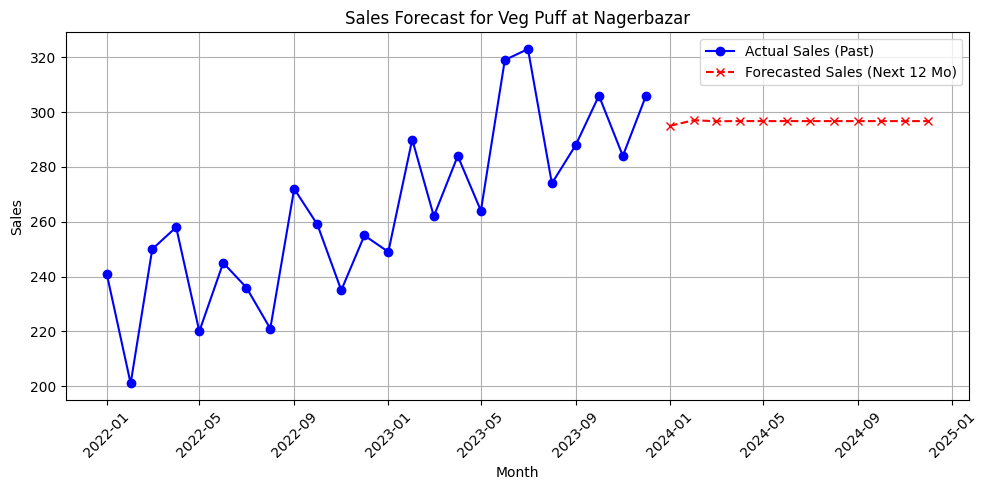

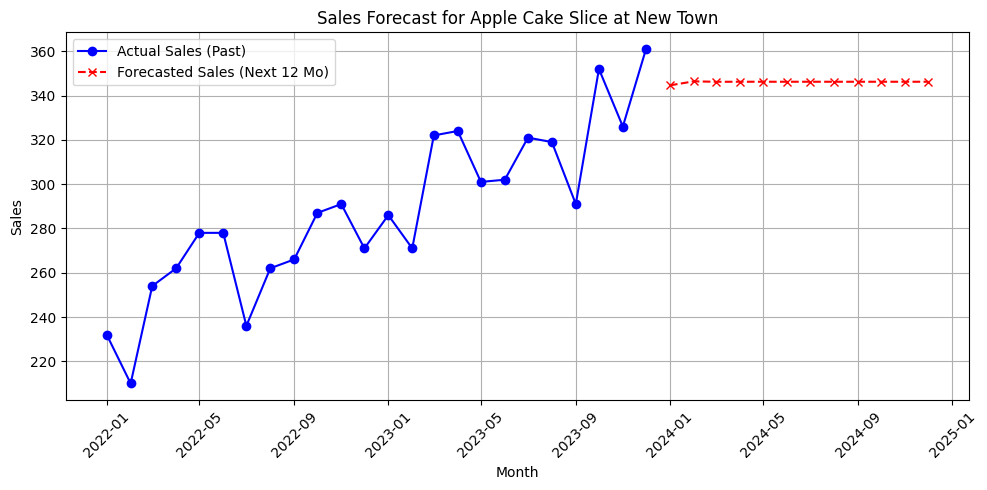

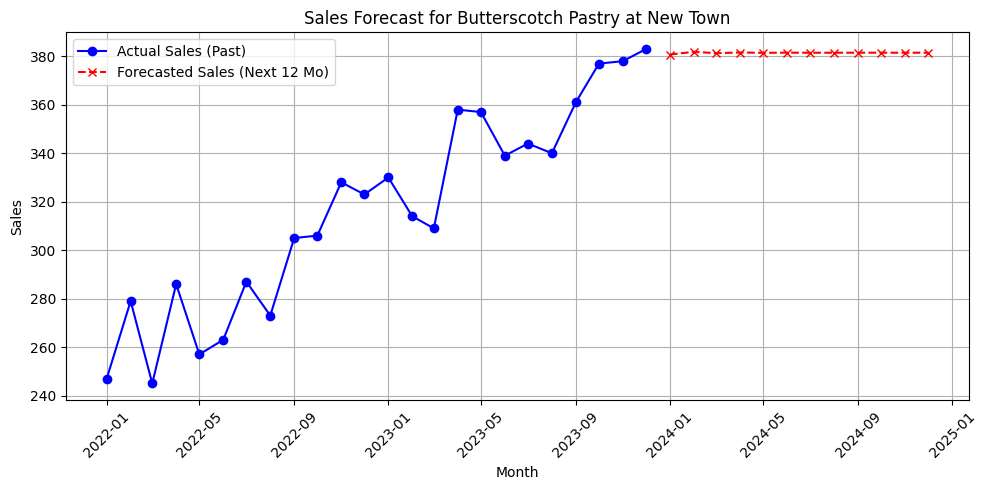

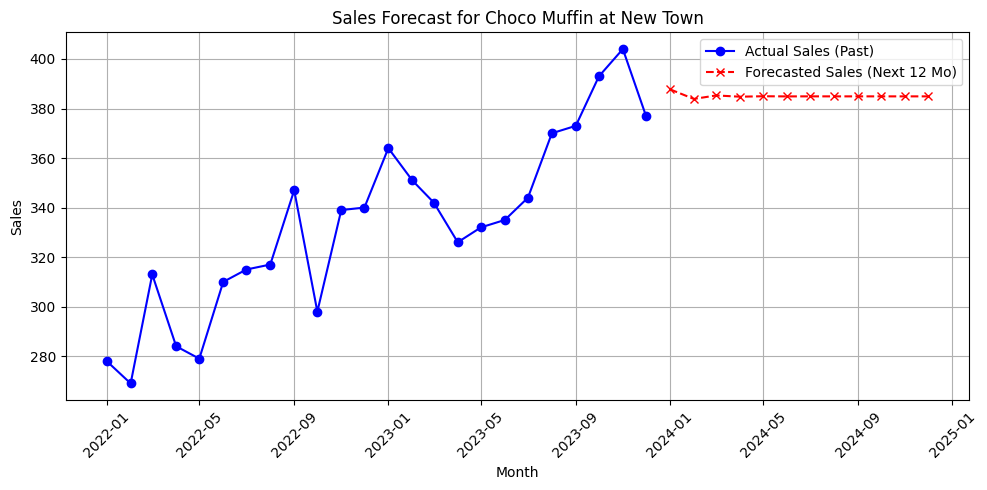

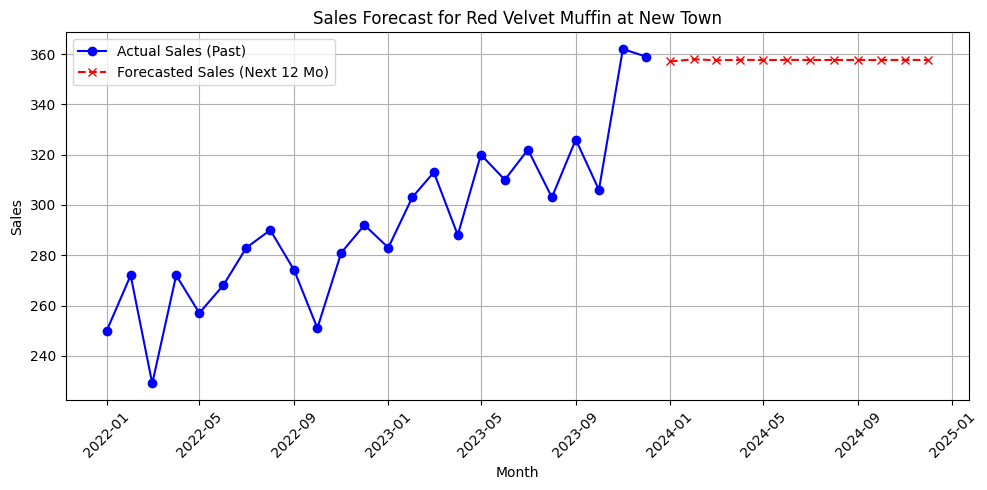

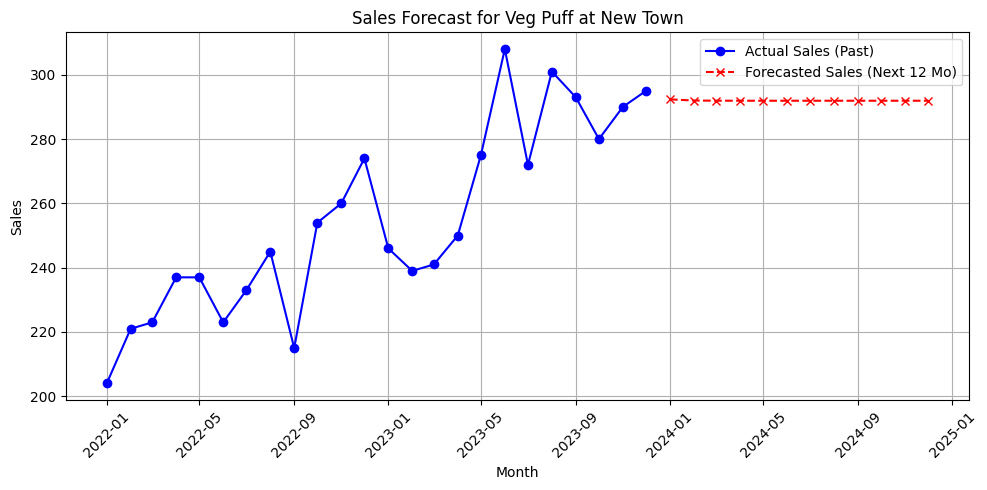

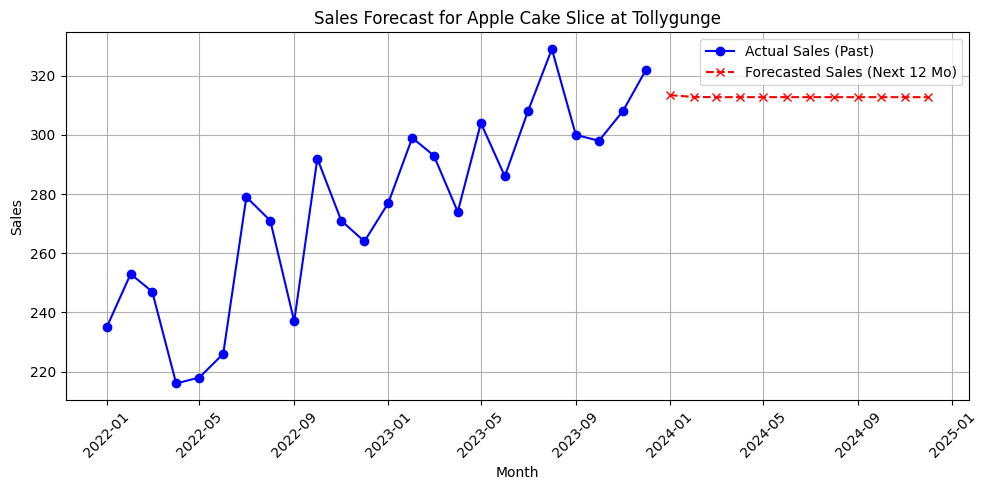

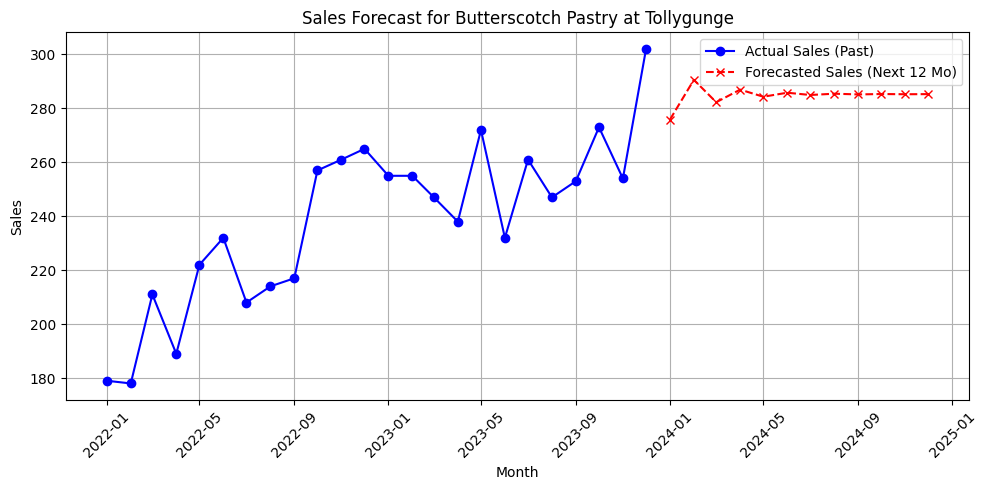

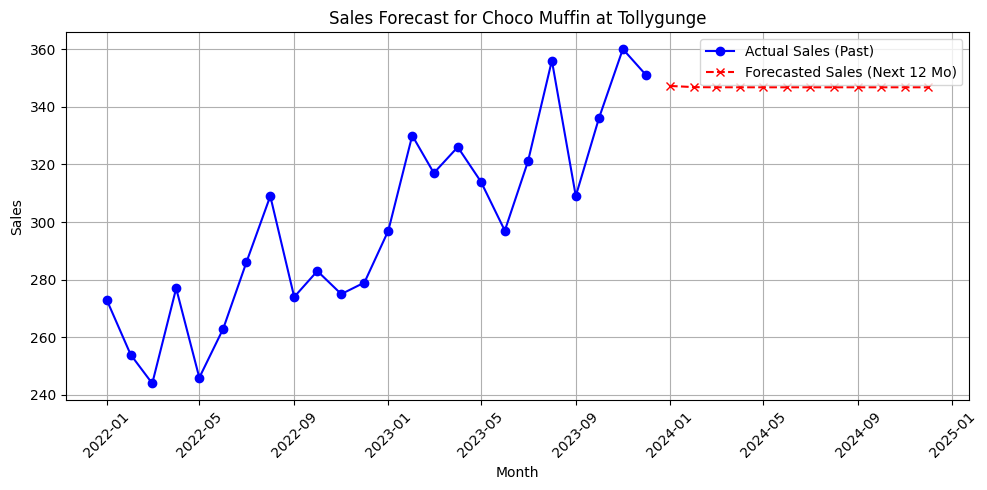

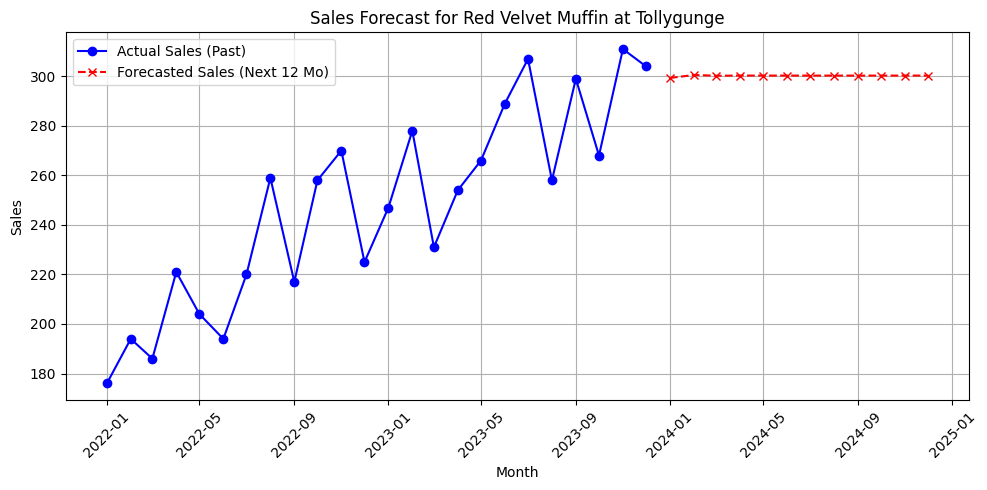

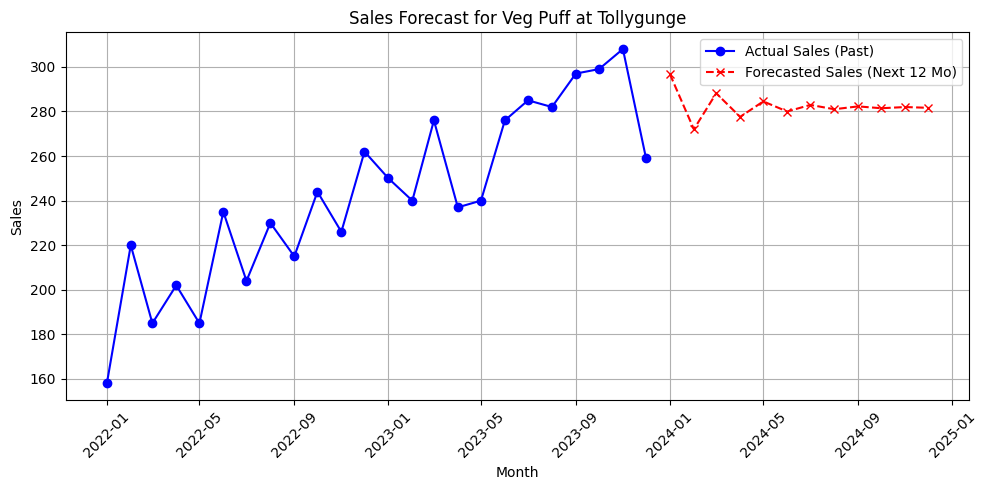

Forecast and plots complete.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
import os
os.makedirs("forecast_plots", exist_ok=True)

warnings.filterwarnings("ignore")

# Load and preprocess data
df = pd.read_csv("kreamz_sales_detailed.csv", parse_dates=["Month"])
df['Month'] = pd.to_datetime(df['Month'])
df['Month'] = df['Month'].dt.to_period('M').dt.to_timestamp()
df['revenue'] = df['Sales'] * df['Price']
low_price_df = df[df['Price'] < 100].copy()

# Forecast collection
forecast_data = []

# Plotting forecast + actual
unique_combos = low_price_df.groupby(['Outlet', 'Item'])

for (outlet, item), group in unique_combos:
    group = group.sort_values('Month')
    sales_ts = group.set_index('Month')['Sales'].asfreq('MS')

    try:
        # Fit ARIMA
        model = ARIMA(sales_ts, order=(1, 1, 1))
        model_fit = model.fit()

        # Forecast next 12 months
        forecast = model_fit.forecast(steps=12)
        forecast_months = pd.date_range(sales_ts.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')
        forecast_series = pd.Series(forecast.values, index=forecast_months)

        # Save forecast
        for date, sale in zip(forecast_months, forecast):
            forecast_data.append({
                'Outlet': outlet,
                'Item': item,
                'Forecast_Month': date.strftime('%Y-%m'),
                'Forecasted_Sales': int(sale)
            })

        # Plot actual + forecast
        plt.figure(figsize=(10, 5))
        plt.plot(sales_ts, label='Actual Sales (Past)', color='blue', marker='o')
        plt.plot(forecast_series, label='Forecasted Sales (Next 12 Mo)', color='red', linestyle='--', marker='x')
        plt.title(f"Sales Forecast for {item} at {outlet}")
        plt.xlabel("Month")
        plt.ylabel("Sales")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.savefig(f"forecast_plots/{outlet}_{item}_forecast.png")  # Save each plot
        plt.show()

    except Exception as e:
        print(f"Error in {outlet} - {item}: {e}")

# Save all forecasts to CSV
forecast_df = pd.DataFrame(forecast_data)
forecast_df.to_csv("kreamz_forecast_12months.csv", index=False)
print("Forecast and plots complete.")
